In [8]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from collections import Counter
import re
import json

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
!nvidia-smi

CUDA available: True
Number of GPUs: 2
Tue Feb 10 05:29:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------

Dataset Overview (Flickr30k)

In [9]:
FEATURE_FILE = "/kaggle/working/flickr30k_features.pkl"  

with open(FEATURE_FILE, "rb") as f:
    features_dict = pickle.load(f)

print(f"Loaded {len(features_dict):,} image features")
print("Sample keys:", list(features_dict.keys())[:5])

Loaded 31,783 image features
Sample keys: ['2715746315.jpg', '3463034205.jpg', '268704620.jpg', '2673564214.jpg', '7535037918.jpg']


Feature Extraction using ResNet50

In [10]:
captions_path = "/kaggle/input/flickr30k/captions.txt"

df = pd.read_csv(captions_path, sep=',', header=0)

df['image'] = df['image'].astype(str).str.strip().str.lower()
df['image'] = df['image'].apply(os.path.basename)

df['caption'] = df['caption'].fillna("a photo of a scene").astype(str).str.strip()

df = df[df['caption'] != ''].reset_index(drop=True)

# Keep only images we actually extracted features for
valid_images = set(k.lower() for k in features_dict.keys())
df = df[df['image'].isin(valid_images)].reset_index(drop=True)

print("After cleaning:")
print("Rows:", len(df))
print("Unique images:", df['image'].nunique())
print("NaN in caption:", df['caption'].isna().sum())
print("Caption types:", df['caption'].apply(type).value_counts())
print(df.head(6))

After cleaning:
Rows: 158915
Unique images: 31783
NaN in caption: 0
Caption types: caption
<class 'str'>    158915
Name: count, dtype: int64
            image                                            caption
0  1000092795.jpg  Two young guys with shaggy hair look at their ...
1  1000092795.jpg  Two young , White males are outside near many ...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .
5    10002456.jpg  Several men in hard hats are operating a giant...


Data Preprocessing & Vocabulary Building

In [11]:
def clean_caption(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-z0-9\s<>'.,?!]", "", text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['caption'] = df['caption'].apply(clean_caption)
df['tokenized_caption'] = df['caption'].apply(lambda x: f"<start> {x} <end>")

all_words = ' '.join(df['tokenized_caption']).split()
word_counts = Counter(all_words)

vocab = ['<pad>', '<start>', '<end>', '<unk>'] + \
        [w for w, cnt in word_counts.most_common() if cnt >= 5]

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

VOCAB_SIZE = len(vocab)
PAD_IDX = word2idx['<pad>']
UNK_IDX = word2idx['<unk>']
START_IDX = word2idx['<start>']
END_IDX   = word2idx['<end>']

print(f"Vocabulary size: {VOCAB_SIZE:,}")

with open("vocab.json", "w") as f:
    json.dump({
        "word2idx": word2idx,
        "idx2word": idx2word,
        "PAD_IDX": PAD_IDX,
        "UNK_IDX": UNK_IDX,
        "START_IDX": START_IDX,
        "END_IDX": END_IDX
    }, f, indent=2)

Vocabulary size: 7,736


In [13]:
MAX_LEN = 25

class CaptioningDataset(Dataset):
    def __init__(self, dataframe, features_dict, word2idx, max_len=MAX_LEN):
        self.df = dataframe.reset_index(drop=True)
        self.features = features_dict
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image']

        if img_name not in self.features:
            raise KeyError(f"Image not found in features: {img_name}")

        feature = torch.tensor(self.features[img_name], dtype=torch.float32)

        caption = row['tokenized_caption']
        tokens = [self.word2idx.get(w, UNK_IDX) for w in caption.split()]
        tokens = tokens[:self.max_len]
        tokens = [START_IDX] + tokens + [END_IDX]

        pad_length = self.max_len + 2 - len(tokens)
        caption_tensor = torch.tensor(tokens + [PAD_IDX] * pad_length, dtype=torch.long)

        return feature, caption_tensor

In [14]:
train_df = df.sample(frac=0.9, random_state=42)
val_df = df.drop(train_df.index)

train_dataset = CaptioningDataset(train_df, features_dict, word2idx)
val_dataset   = CaptioningDataset(val_df, features_dict, word2idx)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples:   {len(val_dataset):,}")

Train samples: 143,024
Val samples:   15,891


Model Architecture

**Encoder:** Linear projection from 2048 → 512  
**Decoder:** Embedding → LSTM → Linear to vocab_size  
**Full model:** Encoder → Decoder with teacher forcing

In [40]:
class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(feature_dim, hidden_size)

    def forward(self, features):
        return self.fc(features)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, captions, hidden_tuple):
        embeds = self.embedding(captions)
        lstm_out, new_hidden_tuple = self.lstm(embeds, hidden_tuple)
        
        logits = self.fc_out(lstm_out)
        return logits, new_hidden_tuple

In [43]:
model = ImageCaptionModel(Encoder(), Decoder(VOCAB_SIZE)).cuda()

In [44]:
model.load_state_dict(torch.load("image_caption_model_epoch20.pt"))
model.eval()
print("Weights loaded back — inference ready")

Weights loaded back — inference ready


Training Process & Results

- Epochs: 20
- Batch size: 64
- Optimizer: Adam lr=3e-4
- Loss: CrossEntropy (ignore <pad>)

In [16]:
model = ImageCaptionModel(Encoder(), Decoder(VOCAB_SIZE)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_losses = []
val_losses = []

for epoch in range(20):
    model.train()
    total_train_loss = 0

    for features, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        features = features.cuda()
        captions = captions.cuda()

        optimizer.zero_grad()
        outputs = model(features, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, VOCAB_SIZE),
                         captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train = total_train_loss / len(train_loader)
    train_losses.append(avg_train)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, captions in val_loader:
            features = features.cuda()
            captions = captions.cuda()
            outputs = model(features, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE),
                             captions[:, 1:].reshape(-1))
            total_val_loss += loss.item()

    avg_val = total_val_loss / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch+1:2d} | Train: {avg_train:.4f} | Val: {avg_val:.4f}")

Epoch 1: 100%|██████████| 2235/2235 [00:43<00:00, 51.67it/s]


Epoch  1 | Train: 3.2447 | Val: 2.7768


Epoch 2: 100%|██████████| 2235/2235 [00:45<00:00, 49.65it/s]


Epoch  2 | Train: 2.6144 | Val: 2.5381


Epoch 3: 100%|██████████| 2235/2235 [00:45<00:00, 49.00it/s]


Epoch  3 | Train: 2.4081 | Val: 2.4270


Epoch 4: 100%|██████████| 2235/2235 [00:45<00:00, 49.40it/s]


Epoch  4 | Train: 2.2741 | Val: 2.3615


Epoch 5: 100%|██████████| 2235/2235 [00:45<00:00, 49.36it/s]


Epoch  5 | Train: 2.1707 | Val: 2.3218


Epoch 6: 100%|██████████| 2235/2235 [00:45<00:00, 49.36it/s]


Epoch  6 | Train: 2.0836 | Val: 2.2958


Epoch 7: 100%|██████████| 2235/2235 [00:45<00:00, 49.38it/s]


Epoch  7 | Train: 2.0067 | Val: 2.2814


Epoch 8: 100%|██████████| 2235/2235 [00:45<00:00, 49.39it/s]


Epoch  8 | Train: 1.9374 | Val: 2.2709


Epoch 9: 100%|██████████| 2235/2235 [00:45<00:00, 49.38it/s]


Epoch  9 | Train: 1.8735 | Val: 2.2695


Epoch 10: 100%|██████████| 2235/2235 [00:45<00:00, 49.33it/s]


Epoch 10 | Train: 1.8135 | Val: 2.2722


Epoch 11: 100%|██████████| 2235/2235 [00:45<00:00, 49.40it/s]


Epoch 11 | Train: 1.7578 | Val: 2.2755


Epoch 12: 100%|██████████| 2235/2235 [00:45<00:00, 49.37it/s]


Epoch 12 | Train: 1.7052 | Val: 2.2843


Epoch 13: 100%|██████████| 2235/2235 [00:45<00:00, 49.33it/s]


Epoch 13 | Train: 1.6554 | Val: 2.2973


Epoch 14: 100%|██████████| 2235/2235 [00:45<00:00, 49.38it/s]


Epoch 14 | Train: 1.6078 | Val: 2.3107


Epoch 15: 100%|██████████| 2235/2235 [00:45<00:00, 49.31it/s]


Epoch 15 | Train: 1.5629 | Val: 2.3249


Epoch 16: 100%|██████████| 2235/2235 [00:45<00:00, 49.32it/s]


Epoch 16 | Train: 1.5202 | Val: 2.3412


Epoch 17: 100%|██████████| 2235/2235 [00:45<00:00, 49.34it/s]


Epoch 17 | Train: 1.4794 | Val: 2.3602


Epoch 18: 100%|██████████| 2235/2235 [00:45<00:00, 49.40it/s]


Epoch 18 | Train: 1.4407 | Val: 2.3835


Epoch 19: 100%|██████████| 2235/2235 [00:45<00:00, 49.36it/s]


Epoch 19 | Train: 1.4036 | Val: 2.4050


Epoch 20: 100%|██████████| 2235/2235 [00:45<00:00, 49.36it/s]


Epoch 20 | Train: 1.3681 | Val: 2.4293


In [17]:
torch.save(model.state_dict(), "image_caption_model_epoch20.pt")
print("Model saved to image_caption_model_epoch20.pt")

Model saved to image_caption_model_epoch20.pt


Inference – Greedy Decoding

In [45]:
def generate_caption_greedy(model, feature, max_len=25, start_token=START_IDX, end_token=END_IDX):
    model.eval()
    with torch.no_grad():
        feature = feature.unsqueeze(0).cuda()         
        hidden = model.encoder(feature)               

        caption = [start_token]
        for _ in range(max_len):
            inp = torch.tensor([caption[-1]], dtype=torch.long).cuda().unsqueeze(0)  
            logits, hidden = model.decoder(inp, hidden.squeeze(0))
            pred_token = logits.argmax(dim=-1).item()
            caption.append(pred_token)
            if pred_token == end_token:
                break

        words = []
        for idx in caption[1:]:  
            if idx == end_token:
                break
            words.append(idx2word.get(idx, "<unk>"))

        return ' '.join(words)

In [49]:
@torch.no_grad()
def generate_caption_greedy(model, feature, max_len=25):
    model.eval()

    feature = feature.unsqueeze(0).cuda()           
    h = model.encoder(feature)                      
    
    h0 = h.unsqueeze(0)                             
    c0 = torch.zeros_like(h0).cuda()
    hidden_tuple = (h0, c0)

    caption_indices = [START_IDX]

    for _ in range(max_len):
        inp = torch.tensor([[caption_indices[-1]]], dtype=torch.long).cuda()  
        
        logits, hidden_tuple = model.decoder(inp, hidden_tuple)
        next_token = logits.argmax(dim=-1).item()
        
        caption_indices.append(next_token)
        if next_token == END_IDX:
            break

    words = []
    for idx in caption_indices[1:]:
        if idx == END_IDX:
            break
        words.append(idx2word.get(idx, "<unk>"))

    words = [idx2word.get(idx, "<unk>") for idx in caption_indices[1:]]
    if END_IDX in caption_indices:
       end_pos = caption_indices.index(END_IDX)
       words = words[:end_pos-1]
    return ' '.join(words).replace("<start>", "").replace("<end>", "").strip()

Qualitative Results

Showing 5 random validation examples:


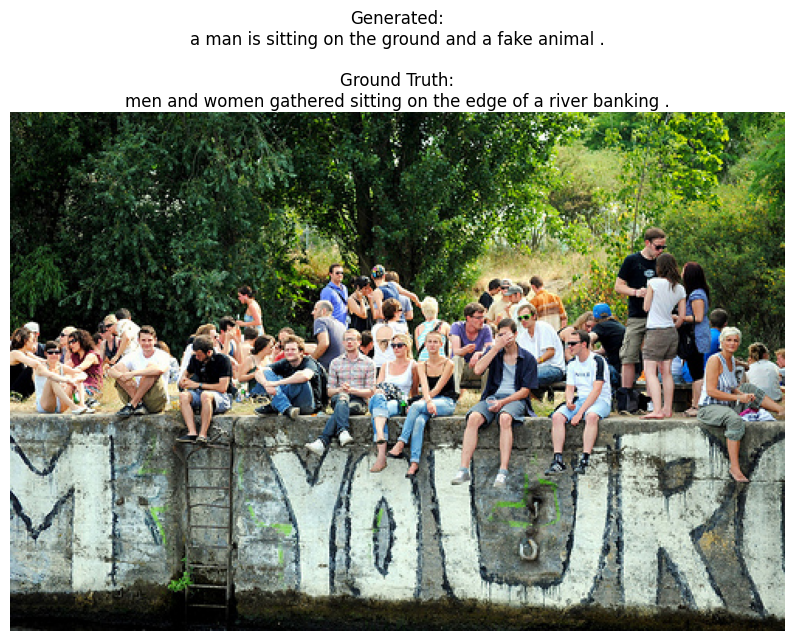

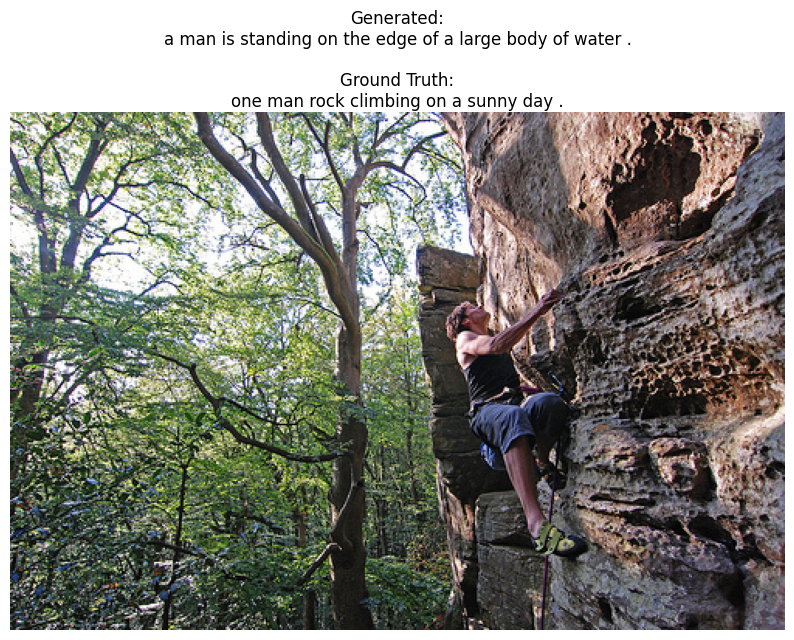

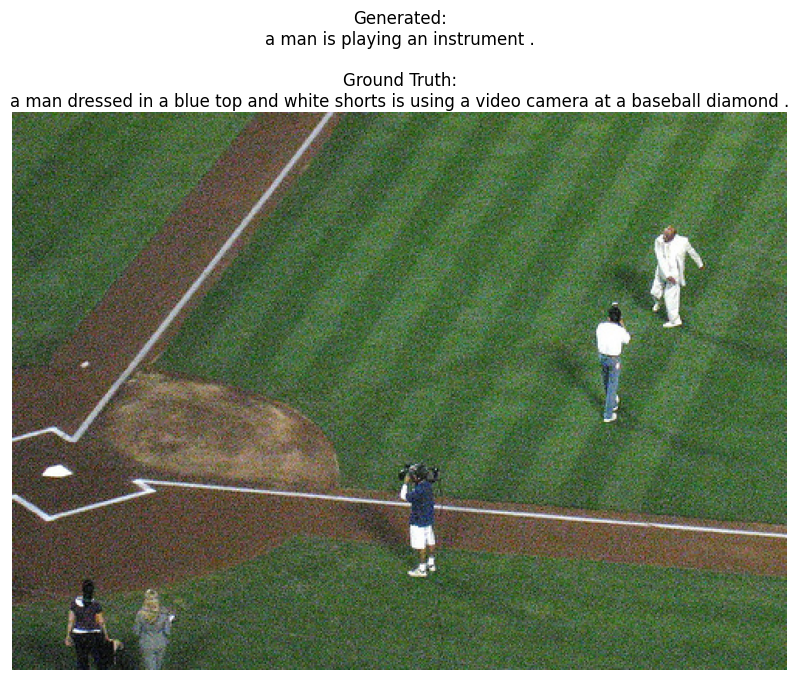

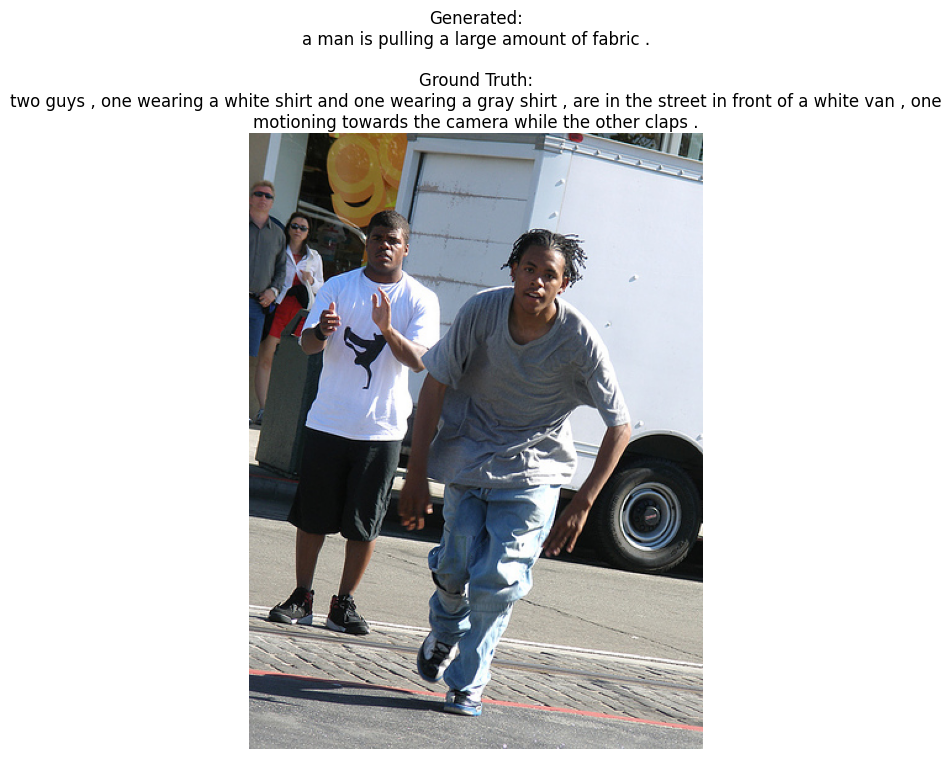

In [50]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_example():
    idx = random.randint(0, len(val_df)-1)
    row = val_df.iloc[idx]
    img_name = row['image']
    gt = row['caption']

    feature = torch.tensor(features_dict[img_name], dtype=torch.float32)
    gen = generate_caption_greedy(model, feature)

    img_path = f"/kaggle/input/flickr30k/Images/{img_name}"
    img = Image.open(img_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated:\n{gen}\n\nGround Truth:\n{gt}", fontsize=12, wrap=True)
    plt.show()

print("Showing 5 random validation examples:")
for _ in range(5):
    show_example()

Loss Curves

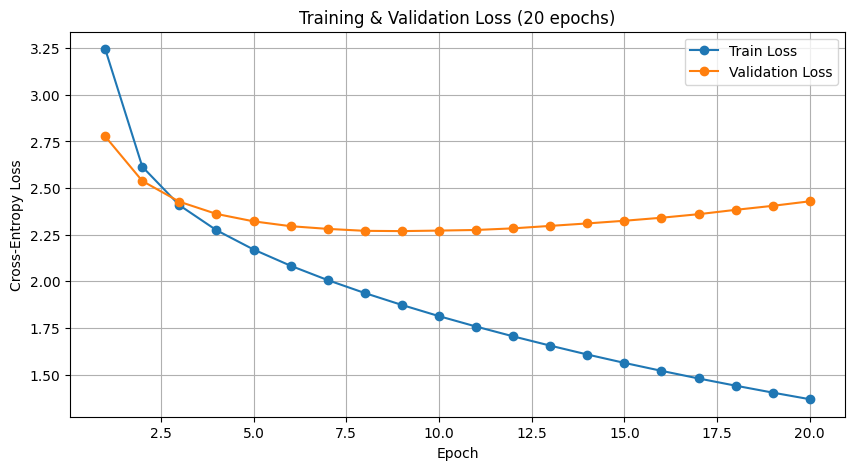

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training & Validation Loss (20 epochs)')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

Quantitative Evaluation – BLEU Score

Average BLEU on 300 validation samples: **0.0256**  
(Note: basic greedy decoding without beam search / attention – expected range for this architecture)

In [53]:
bleu_score = compute_bleu()
print(f"Average BLEU score on 300 samples: {bleu_score:.4f}")

100%|██████████| 300/300 [00:01<00:00, 155.11it/s]

Average BLEU score on 300 samples: 0.0256


In [54]:
torch.save(model.state_dict(), "final_model.pt")
print("Model saved.")

Model saved.


Conclusion

Model successfully generates captions. Future work: add attention mechanism, use beam search, fine-tune ResNet.